In [80]:
# AUDIO_DIR = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/"
SAMPLE_RATE = 22050 # sample rate of the audio file
bit_depth = 16 # bit depth of the audio file
hop_length = 512
n_mfcc =  20 # number of MFCCs features
n_fft=1024, # window size
n_mels = 256 # number of mel bands to generate
win_length = None # window length


# Training parameters
batch_size = 128
learning_rate = 0.001
num_epochs = 20




In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef,confusion_matrix
import torchaudio
import numpy as np



from cnn_model import CNNModel
from datapreprocessing import AudioProcessor


In [82]:
# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_built():  # if you have apple silicon mac
    device = "mps"  # if it doesn't work try device = torch.device('mps')
else:
    device = "cpu"
print(f"Using {device}")

Using mps


In [83]:



path_to_train = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/"
path_to_test = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/test/"

train_dataset = AudioProcessor(audio_dir=path_to_train)
val_dataset = AudioProcessor(audio_dir=path_to_test)
def custom_collate(batch):

    mfccs = []
    labels = []
    
    for mfcc, label in batch:
        mfccs.append(mfcc)
        labels.append(label)

    return torch.stack(mfccs), torch.tensor(labels)



# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)



# Initialize model, loss, and optimizer
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [84]:
def calculate_sdr(target, prediction):
    target = target.float()
    prediction = prediction.float()

    target_energy = torch.sum(target**2)
    error_signal = target - prediction
    error_energy = torch.sum(error_signal**2)

    sdr = 10 * torch.log10(target_energy / error_energy)
    return sdr


In [85]:
def one_hot_encode(labels, num_classes, device):
    return torch.eye(num_classes, device=device)[labels]


In [86]:
def evaluate(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    all_sdrs = []


    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets = one_hot_encode(targets, num_classes=4, device=device).to(device)




            # Forward pass
            outputs = model(inputs)

            # Calculate SDR and append to list
            all_sdrs.append(calculate_sdr(targets, outputs))

            # Calculate loss
            loss = criterion(outputs, targets)

            # Update loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            _, targets = torch.max(targets, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Store targets and predictions for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_sdr = sum(all_sdrs) / len(all_sdrs)


    # Calculate average loss and accuracy
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total

    # Calculate precision, recall, F1-score, and MCC
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    mcc = matthews_corrcoef(all_targets, all_predictions)

    return avg_loss, accuracy, precision, recall, f1_score, mcc, avg_sdr

    # Evaluate the model
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc, avg_sdr = evaluate(val_loader, model, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")
    print(f"Validation SDR: {avg_sdr:.4f}")

In [87]:
# Initialize lists for storing loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_mccs = []
val_sdrs = []


# training loop
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc="Training", ncols=100)):
        inputs = inputs.to(device)

        # targets = targets.to(device)
        targets = one_hot_encode(targets, num_classes=4, device=device).to(device)



        # Zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers

        # Forward pass
        outputs = model(inputs)


        # print(f'outputs shape: {outputs.shape}')
        # print(f'targets shape: {targets.shape}')



        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Update loss
        running_loss += loss.item()

        # Update total and correct
        _, predicted = torch.max(outputs.data, 1)
        _, targets = torch.max(targets, 1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validate and store the validation loss and accuracy

    # Validate and store the validation metrics
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc, val_sdr = evaluate(val_loader, model, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1_score)
    val_mccs.append(val_mcc)
    val_sdrs.append(val_sdr)

    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")

print("Training finished.")



Epoch: 1/20


Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.64s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.3134 | Train Accuracy: 33.99%
Validation Loss: 1.6994 | Validation Accuracy: 2.25%
Validation Precision: 0.2697
Validation Recall: 0.0225
Validation F1-score: 0.0415
Validation MCC: -0.0199
Epoch: 2/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.87s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarn

Train Loss: 1.3717 | Train Accuracy: 38.67%
Validation Loss: 1.7437 | Validation Accuracy: 0.00%
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1-score: 0.0000
Validation MCC: 0.0000
Epoch: 3/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.29s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarn

Train Loss: 1.3336 | Train Accuracy: 41.63%
Validation Loss: 1.7437 | Validation Accuracy: 0.00%
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1-score: 0.0000
Validation MCC: 0.0000
Epoch: 4/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.48s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarn

Train Loss: 1.2335 | Train Accuracy: 49.26%
Validation Loss: 1.7195 | Validation Accuracy: 2.25%
Validation Precision: 0.2697
Validation Recall: 0.0225
Validation F1-score: 0.0415
Validation MCC: -0.0244
Epoch: 5/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.81s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2009 | Train Accuracy: 52.46%
Validation Loss: 1.6087 | Validation Accuracy: 13.48%
Validation Precision: 0.4759
Validation Recall: 0.1348
Validation F1-score: 0.2060
Validation MCC: 0.0541
Epoch: 6/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.20s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1851 | Train Accuracy: 52.46%
Validation Loss: 1.4588 | Validation Accuracy: 26.97%
Validation Precision: 0.4802
Validation Recall: 0.2697
Validation F1-score: 0.3420
Validation MCC: 0.1017
Epoch: 7/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.19s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1728 | Train Accuracy: 59.36%
Validation Loss: 1.3598 | Validation Accuracy: 35.96%
Validation Precision: 0.5305
Validation Recall: 0.3596
Validation F1-score: 0.4260
Validation MCC: 0.1753
Epoch: 8/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.45s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1549 | Train Accuracy: 61.08%
Validation Loss: 1.4517 | Validation Accuracy: 25.84%
Validation Precision: 0.4788
Validation Recall: 0.2584
Validation F1-score: 0.3346
Validation MCC: 0.1064
Epoch: 9/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.32s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1255 | Train Accuracy: 58.37%
Validation Loss: 1.4954 | Validation Accuracy: 22.47%
Validation Precision: 0.4380
Validation Recall: 0.2247
Validation F1-score: 0.2848
Validation MCC: 0.0282
Epoch: 10/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.28s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1349 | Train Accuracy: 57.88%
Validation Loss: 1.4184 | Validation Accuracy: 31.46%
Validation Precision: 0.5182
Validation Recall: 0.3146
Validation F1-score: 0.3652
Validation MCC: 0.0945
Epoch: 11/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.35s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.0950 | Train Accuracy: 61.33%
Validation Loss: 1.3867 | Validation Accuracy: 33.71%
Validation Precision: 0.5217
Validation Recall: 0.3371
Validation F1-score: 0.4023
Validation MCC: 0.1595
Epoch: 12/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.14s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.0986 | Train Accuracy: 60.10%
Validation Loss: 1.3249 | Validation Accuracy: 41.57%
Validation Precision: 0.5650
Validation Recall: 0.4157
Validation F1-score: 0.4754
Validation MCC: 0.2396
Epoch: 13/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.47s/it]


Train Loss: 1.0722 | Train Accuracy: 63.30%
Validation Loss: 1.1990 | Validation Accuracy: 55.06%
Validation Precision: 0.6057
Validation Recall: 0.5506
Validation F1-score: 0.5439
Validation MCC: 0.3295
Epoch: 14/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.41s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1236 | Train Accuracy: 57.39%
Validation Loss: 1.3473 | Validation Accuracy: 39.33%
Validation Precision: 0.5505
Validation Recall: 0.3933
Validation F1-score: 0.4544
Validation MCC: 0.2001
Epoch: 15/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.30s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1011 | Train Accuracy: 62.56%
Validation Loss: 1.4005 | Validation Accuracy: 33.71%
Validation Precision: 0.4694
Validation Recall: 0.3371
Validation F1-score: 0.3917
Validation MCC: 0.1277
Epoch: 16/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.56s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1073 | Train Accuracy: 61.33%
Validation Loss: 1.3787 | Validation Accuracy: 37.08%
Validation Precision: 0.5444
Validation Recall: 0.3708
Validation F1-score: 0.4166
Validation MCC: 0.1982
Epoch: 17/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.99s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1403 | Train Accuracy: 60.59%
Validation Loss: 1.1748 | Validation Accuracy: 57.30%
Validation Precision: 0.6224
Validation Recall: 0.5730
Validation F1-score: 0.5298
Validation MCC: 0.3505
Epoch: 18/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.26s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1127 | Train Accuracy: 65.76%
Validation Loss: 1.1275 | Validation Accuracy: 62.92%
Validation Precision: 0.6610
Validation Recall: 0.6292
Validation F1-score: 0.5743
Validation MCC: 0.4406
Epoch: 19/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.81s/it]


Train Loss: 1.1129 | Train Accuracy: 62.32%
Validation Loss: 1.1773 | Validation Accuracy: 56.18%
Validation Precision: 0.5423
Validation Recall: 0.5618
Validation F1-score: 0.5013
Validation MCC: 0.3226
Epoch: 20/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.38s/it]


Train Loss: 1.0516 | Train Accuracy: 65.52%
Validation Loss: 1.1541 | Validation Accuracy: 58.43%
Validation Precision: 0.5710
Validation Recall: 0.5843
Validation F1-score: 0.5286
Validation MCC: 0.3624
Training finished.


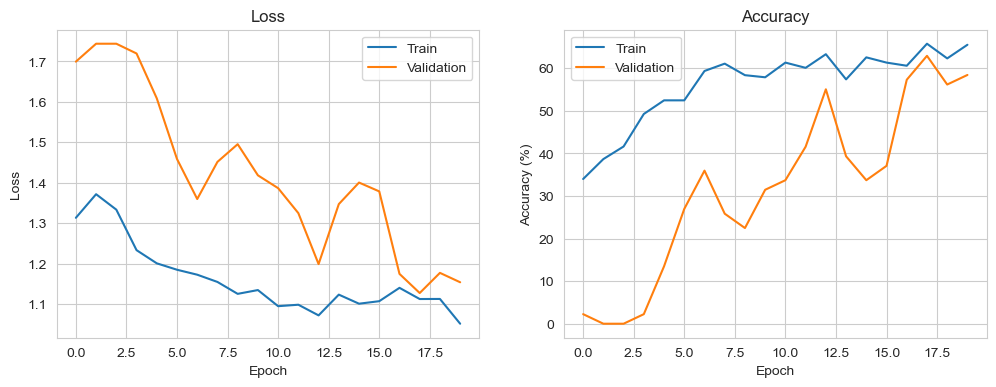

In [88]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy
ax2.plot(train_accuracies, label='Train')
ax2.plot(val_accuracies, label='Validation')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.show()

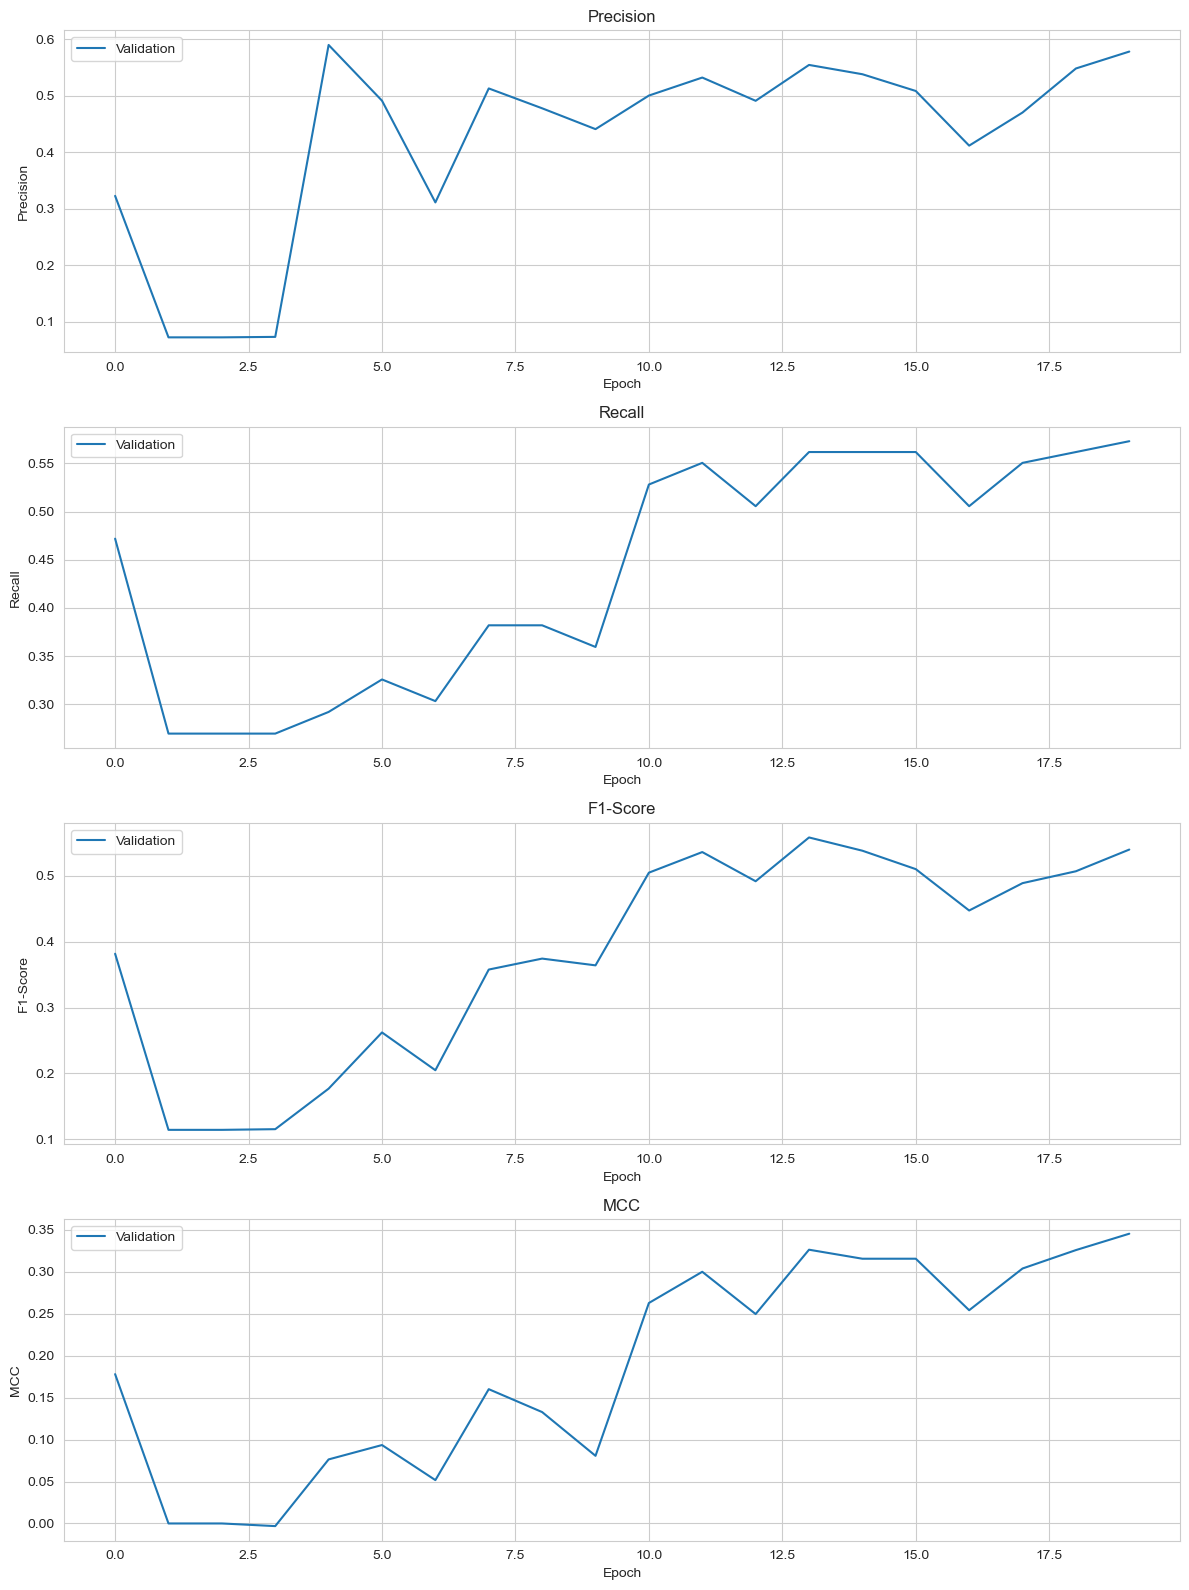

In [68]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

# Precision
ax1.plot(val_precisions, label='Validation')
ax1.set_title('Precision')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Precision')
ax1.legend()

# Recall
ax2.plot(val_recalls, label='Validation')
ax2.set_title('Recall')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Recall')
ax2.legend()

# F1-score
ax3.plot(val_f1_scores, label='Validation')
ax3.set_title('F1-Score')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-Score')
ax3.legend()

# MCC
ax4.plot(val_mccs, label='Validation')
ax4.set_title('MCC')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('MCC')
ax4.legend()

plt.tight_layout()
plt.show()


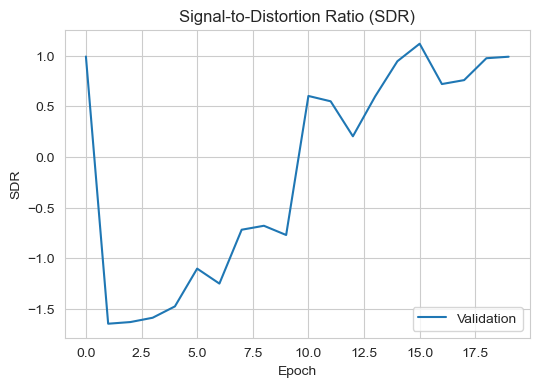

In [69]:
# Convert list of tensors to list of numpy arrays (if necessary)
if isinstance(val_sdrs[0], torch.Tensor):
    val_sdrs_np = [sdr.cpu().numpy() for sdr in val_sdrs]
else:
    val_sdrs_np = val_sdrs

# Plotting SDR
fig, ax = plt.subplots(figsize=(6, 4))

# SDR
ax.plot(val_sdrs_np, label='Validation')
ax.set_title('Signal-to-Distortion Ratio (SDR)')
ax.set_xlabel('Epoch')
ax.set_ylabel('SDR')
ax.legend()

plt.show()


/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


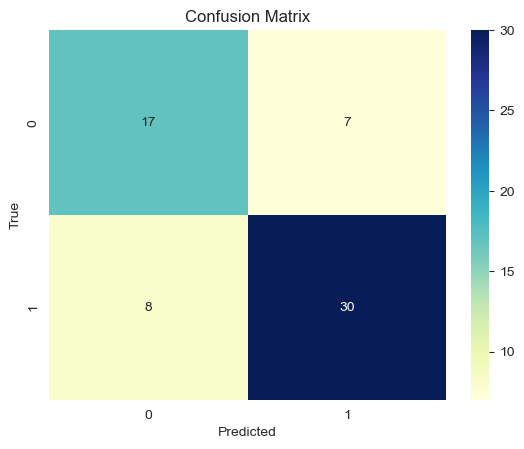

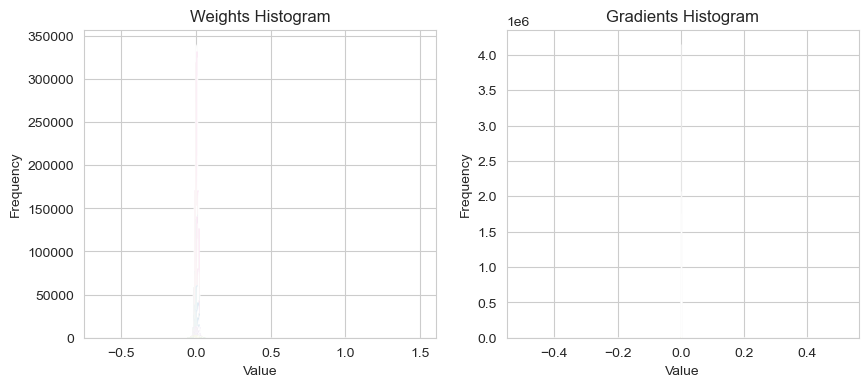

In [70]:
def plot_confusion_matrix(y_true, y_pred, labels, ax=None, title=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if ax is None:
        _, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if title:
        ax.set_title(title)

def get_weights_gradients(model):
    weights = []
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights.append(param.data.cpu().numpy())
            gradients.append(param.grad.data.cpu().numpy())
    return weights, gradients

def plot_histograms(weights, gradients, figsize=(10, 4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    for w in weights:
        ax1.hist(w.flatten(), bins=100, alpha=0.5)
    ax1.set_title("Weights Histogram")
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Frequency")

    for g in gradients:
        ax2.hist(g.flatten(), bins=100, alpha=0.5)
    ax2.set_title("Gradients Histogram")
    ax2.set_xlabel("Value")
    ax2.set_ylabel("Frequency")

    plt.show()

# Get true labels and predictions on the validation set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title="Confusion Matrix")

# Extract weights and gradients and plot histograms
weights, gradients = get_weights_gradients(model)
plot_histograms(weights, gradients)


In [71]:
# Save the trained model
torch.save(model.state_dict(), "CNNModel_speech_music_discrimination.pth")
print("Model saved.")

Model saved.


In [ ]:
# # this part doesn't work any more because of the change in the model -> "attention" layer
# # Show model summary
# try:
#     from torchsummary import summary
#     print("\nModel summary:")
#
#     original_device = device
#     if device == 'mps': # because MPS is not supported by torchsummary
#         device = 'cpu'
#
#
#     class ModelWrapper(nn.Module):
#         def __init__(self, module):
#             super(ModelWrapper, self).__init__()
#             self.module = module
#
#         def forward(self, x):
#             return self.module(x)
#
#     model = ModelWrapper(CNNModel(mfcc_dim=32, output_ch=4)).to(device)
#     summary(model, input_size=(1, 32, 112))
#
#     if original_device == 'mps': # Restore original device
#         device = original_device
#         model.to(device)
#
# except ImportError:
#     print("\nPlease install torchsummary to display the model summary. Use `pip install torchsummary`.")